## Data

In [4]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
%matplotlib inline

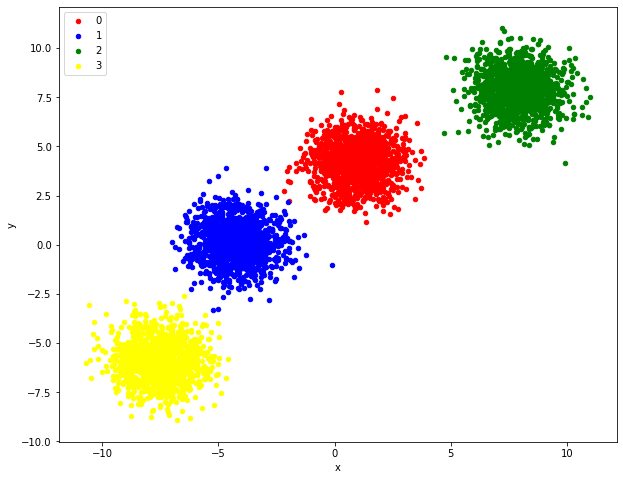

In [92]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

pyplot.rcParams["figure.figsize"] = (10,8)


# generate 2d classification dataset
X, y = make_blobs(n_samples=5000, centers=4, n_features=2, random_state=3)

# X = X.astype(int)


# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# pyplot.show()

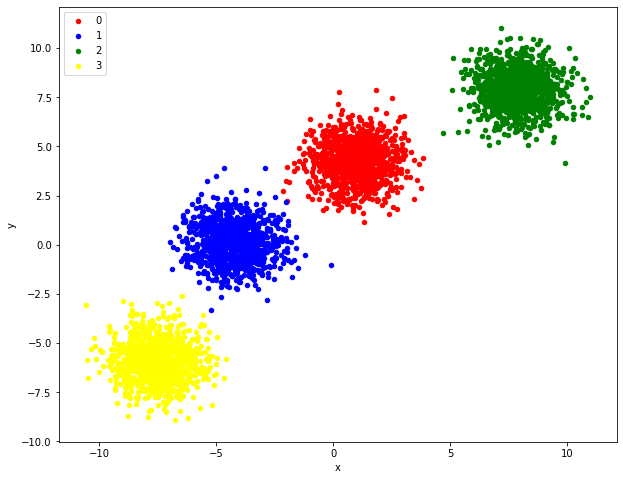

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X_train[:,0], y=X_train[:,1], label=y_train))
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# pyplot.show()

## Spherical Gaussian 
The likelihood for each point is:
![alt text](sg.png "Title")

Assuming there are exactly k clusters 
![alt text](sg2.png "Title")

![alt text](sg3.png "Title")

## Model Parameters
![alt text](mp.png "Title")

## Maximum Likelihood Objective 
![alt text](obj2.png "Title")

## Initialization

In [94]:
from random import randint
import math
def get_initial_mean(X, k):
    
    random_means = []
    for i in range(0,k):
        r = randint(0, len(X))
        random_means.append(X[r])
    return random_means

def get_full_mean(X):
    s = 0
    for i in X:
        s = s+i
        
    return s/len(X)

def get_full_var(X):
    mean = get_full_mean(X)
    d = len(X[0])
    n = len(X)
    
    var = 0
    for point in X:
        total = 0
        for dim in range(len(point)):
            total = total + math.pow((point[dim]-mean[dim]),2)
        var = var + total
        
    r = var/(d*n)
    return r

def get_initial_var(X, k):
    var = get_full_var(X)
    initial_var = []
    for i in range(0,k):
        initial_var.append(var)
    return initial_var
    
def get_initial_pi(X, k):
    initial_pi = []
    for i in range(0,k):
        initial_pi.append(1/k)
    return initial_pi

## EM Algorithm
![alt.text](estep.png "Title")
![alt.text](mstep.png "Title")

In [95]:
import numpy as np
def p(x, means, var):
    
    d= len(x)
    total=0
    for i in range(d):
        total += math.pow((x[i]-means[i]),2)
    term1 = 1/math.pow((2*math.pi*var), (d/2))
    term3 = (-1)/(2*var)
    term2 = np.exp(term3*total)
    
    return term1*term2

In [111]:
import numpy as np
from collections import defaultdict
def em_algorithm(X, k, iteration):
    
    
    #get initial params
    mean_s = get_initial_mean(X, k)
    var_s = get_initial_var(X, k)
    pi_s = get_initial_pi(X, k)
    
    p_i_t_s = defaultdict(lambda: defaultdict(int))
    
    n_i_s = [0]*k
    n = len(X)
    d = len(X[0])
    
    for iteration in range(0,iteration):
#         print("iter ", iteration)
#         print("means ", mean_s)
#         print("var_s ", var_s)
#         print("pi_s ", pi_s)
#         print("n_i_s ", n_i_s)

#         print("p_i_t_s 1 ",p_i_t_s)
        # E Step
        for t in range(n):
            denom = 0
            
            for i in range(k):
                denom = denom + (pi_s[i]*p(X[t], mean_s[i], var_s[i]))
            for i in range(k):
                numer = pi_s[i]*p(X[t], mean_s[i], var_s[i])
                p_i_t_s[t][i] = numer/denom
                
        
        #M Step
            #ni
        for i in range(k):
            s=0
            for t in range(n):
                s=s+p_i_t_s[t][i]
            n_i_s[i]=s
        
            #pi
        for i in range(k):
            pi_s[i] = n_i_s[i]/n
        
            #meani
        for i in range(k):
            sumi = 0
            for t in range(n):
                
                sumi = sumi+ (X[t]*p_i_t_s[t][i])
            mean_s[i] = sumi/n_i_s[i]
        
            #vari
        for i in range(k):
            sumi = 0
            for t in range(n):
                total=0
                for dim in range(d):
                    total = total+(math.pow((X[t][dim]-mean_s[i][dim]),2))       
                sumi = sumi + (total*p_i_t_s[t][i]) 
            
            var_s[i] = sumi/(n_i_s[i]*d)
        predict(pi_s, mean_s, var_s, p_i_t_s, X, n, k)
    
    
    predict(pi_s, mean_s, var_s, p_i_t_s, X, n, k)
    return pi_s, mean_s, var_s
        
        

In [120]:

def predict(pi_s, mean_s, var_s, p_i_t_s, X, n, k):
    y_predicted = []

    for t in range(n):
        denom = 0
        for i in range(k):
            denom = denom + (pi_s[i]*p(X[t], mean_s[i], var_s[i]))
        for i in range(k):
            numer = pi_s[i]*p(X[t], mean_s[i], var_s[i])
            p_i_t_s[t][i] = numer/denom
        pits = p_i_t_s[t]
        cluster = max(pits, key=pits.get)
        y_predicted.append(cluster)
    
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y_predicted))
    colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
    fig, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

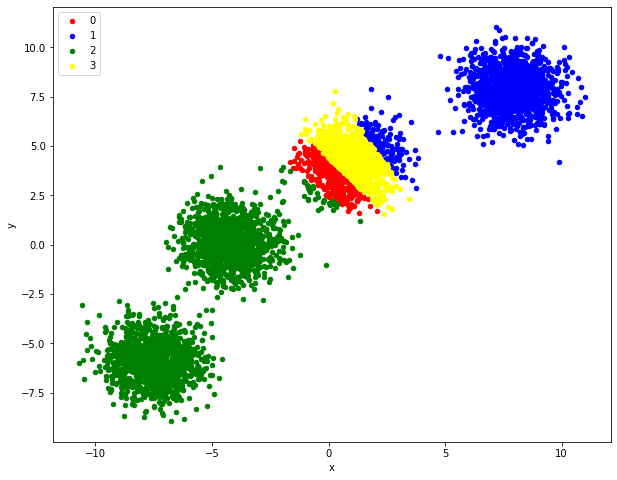

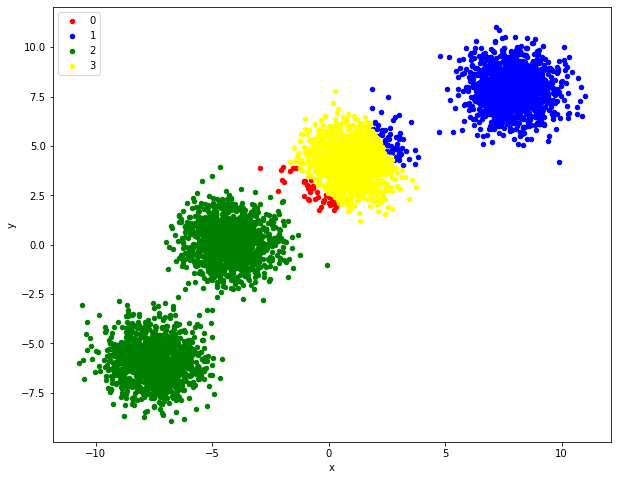

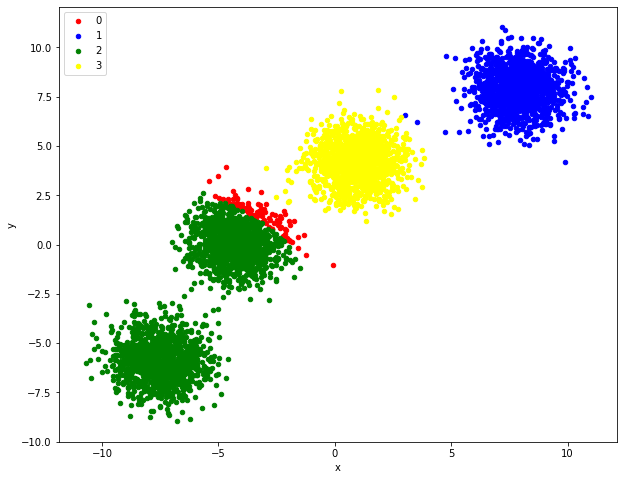

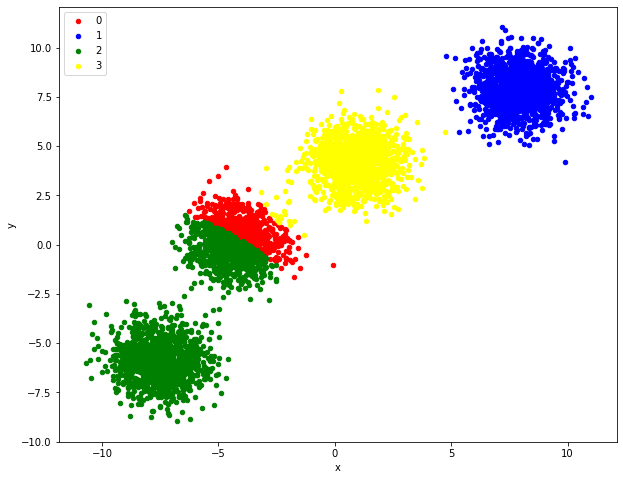

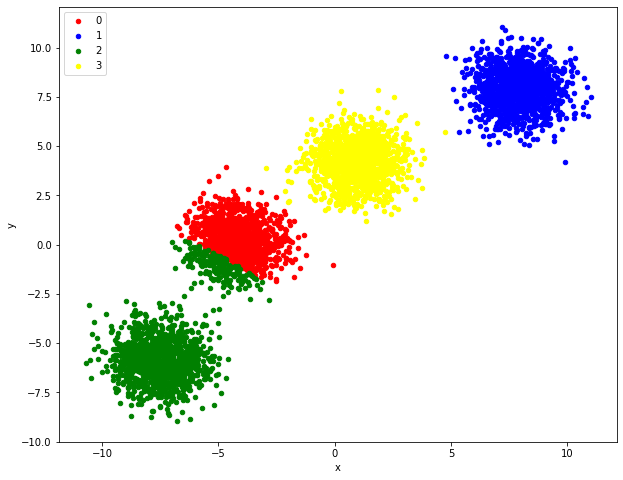

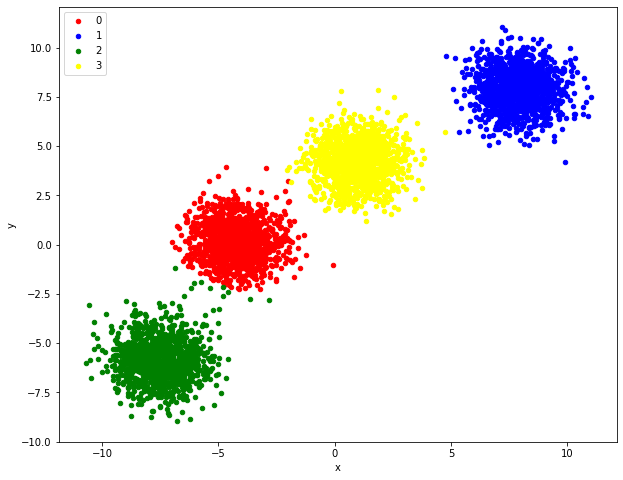

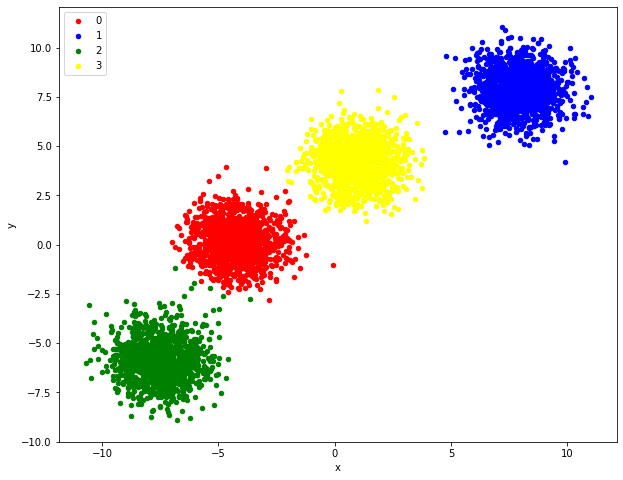

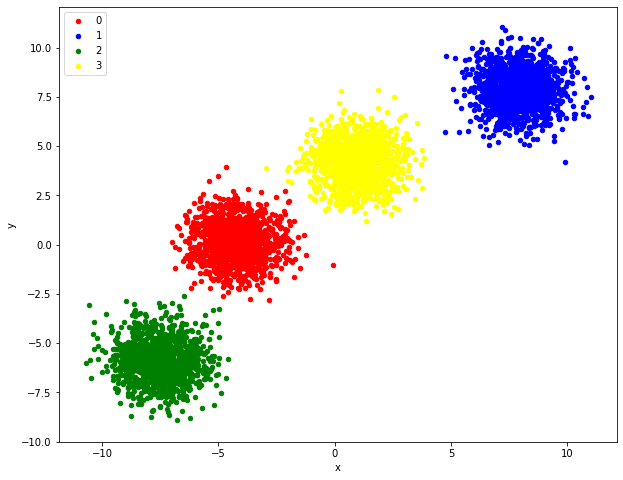

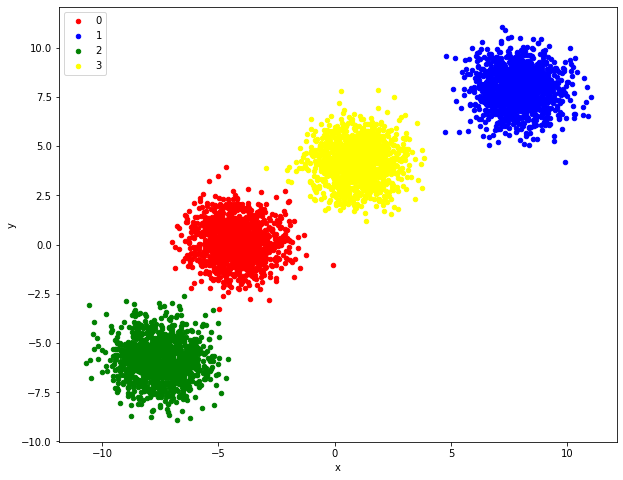

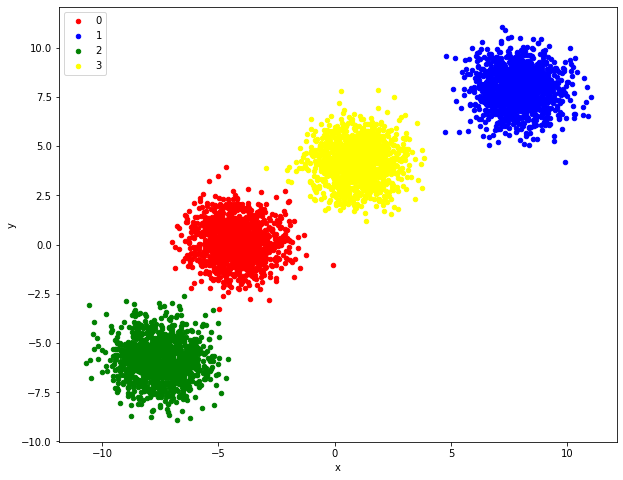

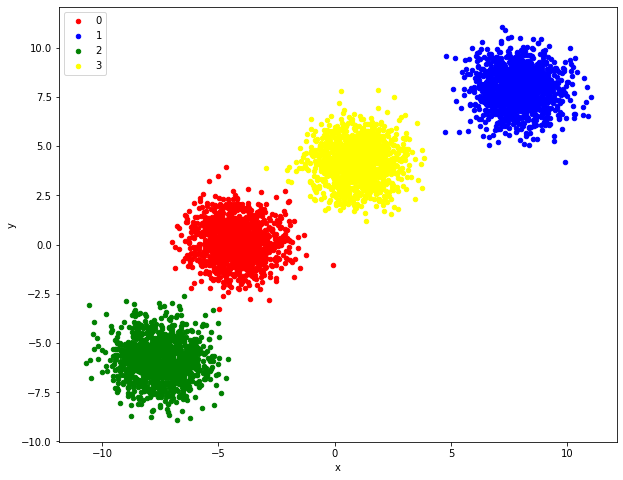

In [121]:
p_i, mean_i, var_i = em_algorithm(X, 4, 10)

In [ ]:
y_pred = predict(X_test,p_i, mean_i, var_i)

In [ ]:
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# pyplot.show()